# Automatic Classification of Injury Severity in OSHA Incident Narratives Using Traditional NLP Techniques and Deep Learning Approaches

**Student Name:** Anthony Eddei Kwofie  
**Programme:** MSc Artificial Intelligence and Data Science  
**Institution:** University of Hull – London Campus  
**Module:** Applied Artificial Intelligence  
**Date:** December 2025

---

## Step 1 — Importing Required Libraries

In this step, I set up the Python environment required for the entire project. I imported libraries for data manipulation using Pandas and NumPy, text preprocessing with regular expressions, and visualisation using Matplotlib, Seaborn, and WordCloud.

To support model development, I loaded traditional machine learning algorithms such as Naïve Bayes and Logistic Regression, alongside deep learning components from TensorFlow for building a Bidirectional LSTM model. I also imported the sentence-transformers library to enable transformer-based text embeddings using DistilBERT.

Finally, I included evaluation metrics for accuracy, precision, recall, F1-score, ROC analysis, and confusion matrices, as well as SMOTE and class-weighting utilities to handle class imbalance later in the analysis.

In [1]:
# CELL 1: Importing required libraries
# In this project, I imported the libraries needed for loading data,
# preprocessing text, visualising results, and implementing both traditional
# machine learning models and deep learning models.

# Data handling
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Text preprocessing
import re
import string

# Train-test split
from sklearn.model_selection import train_test_split

# Traditional NLP feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Traditional models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Model evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, precision_recall_curve
)

# Imbalance handling
from imblearn.over_sampling import SMOTE
from sklearn.utils import class_weight

# Deep learning (LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Transformer embedding model
from sentence_transformers import SentenceTransformer

# Progress bar
from tqdm import tqdm


## Step 2 — Loading the OSHA Dataset

I loaded the OSHA accident narrative dataset from my local directory. When I initially attempted to read the CSV file using the default UTF-8 encoding, a decoding error occurred, indicating the presence of extended or non-UTF-8 characters.

To resolve this, I reloaded the dataset using latin-1 encoding, which successfully handled the special characters without corrupting the data. After loading the file into a Pandas DataFrame, I inspected the first few records to confirm that the narrative text and associated fields had been read correctly.

In [2]:
# CELL 2: Loading the dataset

file_path = r"C:\Users\HP\Desktop\ARTIFICIAL INTELLIGENCE AND DATA SCIENCE - HULL LONDON\MSC. AI & DATA SCIENCE\FINAL ASSESSMENT - MSC AI & DATA SCIENCE\SEMESTER 2\APPLIED AI\NLP\DATASET\RAW\OSHA_Incident-Reports_Jan-2015_Dec-22.csv"

df = pd.read_csv(file_path, encoding='latin-1', low_memory=False)

# I displayed the first few rows to confirm successful loading.
df.head()


,ID,UPA,EventDate,Employer,Address1,Address2,City,State,Zip,Latitude,...,Nature,NatureTitle,Part of Body,Part of Body Title,Event,EventTitle,Source,SourceTitle,Secondary Source,Secondary Source Title
0,2015010015,931176,1/1/2015,FCI Otisville Federal Correctional Institution,Two Mile Drive,NaN,OTISVILLE,NEW YORK,10963.0,41.46,...,111,Fractures,513,Lower leg(s),1214,Injured by physical contact with person while ...,5721,Co-worker,5772.0,Inmate or detainee in custody
1,2015010016,930267,1/1/2015,Kalahari Manufacturing LLC,171 Progress Drive,NaN,LAKE DELTON,WISCONSIN,53940.0,43.59,...,1522,Second degree heat (thermal) burns,519,"Leg(s), n.e.c.",317,"Ignition of vapors, gases, or liquids",7261,"Welding, cutting, and blow torches",NaN,NaN
2,2015010018,929823,1/1/2015,Schneider National Bulk Carrier,420 CORAOPOLIS ROAD,NaN,CORAOPOLIS,PENNSYLVANIA,15108.0,40.49,...,10,"Traumatic injuries and disorders, unspecified",9999,Nonclassifiable,4331,Other fall to lower level less than 6 feet,8421,"Semi, tractor-trailer, tanker truck",741.0,Ladders-fixed
3,2015010019,929711,1/1/2015,PEPSI BOTTLING GROUP INC.,4541 HOUSTON AVE.,NaN,MACON,GEORGIA,31206.0,32.77,...,1972,"Soreness, pain, hurt-nonspecified injury",510,"Leg(s), unspecified",640,Caught in or compressed by equipment or object...,8623,Pallet jack-powered,8420.0,"Truck-motorized freight hauling and utility, u..."
4,2015010020,929642,1/1/2015,North American Pipe Corporation,210 South Arch Street,NaN,JANESVILLE,WISCONSIN,53545.0,42.67,...,111,Fractures,4429,"Finger(s), fingernail(s), n.e.c.",6411,Caught in running equipment or machinery durin...,350,"Metal, woodworking, and special material machi...",NaN,NaN


## Step 3 — Selecting Relevant Columns and Handling Missing Values

At this stage, I reduced the dataset to include only the variables required for the NLP classification task. The original dataset contained many metadata fields that were not relevant for text-based injury severity prediction, so I retained only the accident narrative and the two severity indicators: hospitalisation and amputation.

I then checked for missing narrative text and removed any records without descriptions, as these could not be used for feature extraction or model training. Removing these entries did not bias the dataset, since records without text provide no meaningful information for an NLP model. After filtering, I confirmed that no missing values remained in the selected columns.


In [3]:
# CELL 3: Selecting relevant columns and handling missing values

# I kept only the narrative text and the two target labels
df = df[['Final Narrative', 'Hospitalized', 'Amputation']]

print("Original dataset shape:", df.shape)

# I removed rows where the narrative text was missing
df = df[df['Final Narrative'].notnull()].reset_index(drop=True)
df['Amputation'] = df['Amputation'].fillna(0)


print("Dataset shape after dropping rows with missing narratives:", df.shape)

# I checked for any remaining missing values
print("\nRemaining null values:")
print(df.isnull().sum())

df.head()


Original dataset shape: (79351, 3)
Dataset shape after dropping rows with missing narratives: (79351, 3)

Remaining null values:
Final Narrative    0
Hospitalized       0
Amputation         0
dtype: int64


,Final Narrative,Hospitalized,Amputation
0,Three correctional facility guards were escort...,1.0,0.0
1,Employee in the Machine Shop received second d...,1.0,0.0
2,A truck driver fell approximately 4 feet while...,1.0,0.0
3,An employee's leg was pinned between a truck a...,1.0,0.0
4,An employee working on the Line 6 Auto-Beller ...,1.0,0.0


## Step 4 — Text Preprocessing and Creation of Binary Target Labels

Here, I cleaned and normalised the accident narratives to prepare them for modelling. I converted all text to lowercase, removed punctuation and newline characters, and collapsed extra whitespace to reduce noise during tokenisation.

I also standardised the target variables by converting the hospitalisation and amputation fields into clean binary labels. All non-positive values were mapped to zero, ensuring consistency and avoiding ambiguity during model training. The processed dataset was then saved so that preprocessing did not need to be repeated in later experiments.

In [4]:
# CELL 4: Text preprocessing and creation of binary target labels

def clean_text(text):
    # I converted text to lowercase
    text = text.lower()
    # I removed newline characters
    text = re.sub(r'\n', ' ', text)
    # I removed punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # I removed extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# I applied the cleaning function to the narrative column
df['clean_text'] = df['Final Narrative'].apply(clean_text)

# I standardised the binary target labels
df['Hospitalized'] = df['Hospitalized'].apply(lambda x: 1 if x == 1 else 0)
df['Amputation'] = df['Amputation'].apply(lambda x: 1 if x == 1 else 0)

# I checked the cleaned output
df[['Final Narrative', 'clean_text', 'Hospitalized', 'Amputation']].head()

# I saved the processed dataset
processed_path = r"C:\Users\HP\Desktop\ARTIFICIAL INTELLIGENCE AND DATA SCIENCE - HULL LONDON\MSC. AI & DATA SCIENCE\FINAL ASSESSMENT - MSC AI & DATA SCIENCE\SEMESTER 2\APPLIED AI\NLP\DATASET\PROCESSED\OSHA_Incident_Processed.csv"
df.to_csv(processed_path, index=False)

print("Processed dataset saved to:", processed_path)


Processed dataset saved to: C:\Users\HP\Desktop\ARTIFICIAL INTELLIGENCE AND DATA SCIENCE - HULL LONDON\MSC. AI & DATA SCIENCE\FINAL ASSESSMENT - MSC AI & DATA SCIENCE\SEMESTER 2\APPLIED AI\NLP\DATASET\PROCESSED\OSHA_Incident_Processed.csv


## Step 5 — Exploratory Data Analysis (EDA)

I carried out an initial exploratory data analysis to understand the structure and distribution of the processed dataset. I first confirmed the final dataset size and then examined the class distributions for both hospitalisation and amputation outcomes.

To visualise potential imbalance, I plotted bar charts for each target variable. This step was important because class imbalance can strongly influence model behaviour. The findings from this analysis informed my later use of SMOTE, class weighting, and threshold tuning.

Dataset shape after preprocessing: (79351, 4)

Class distribution for Hospitalization:
Hospitalized
1    63702
0    15649
Name: count, dtype: int64

Class distribution for Amputation:
Amputation
0    58426
1    20925
Name: count, dtype: int64


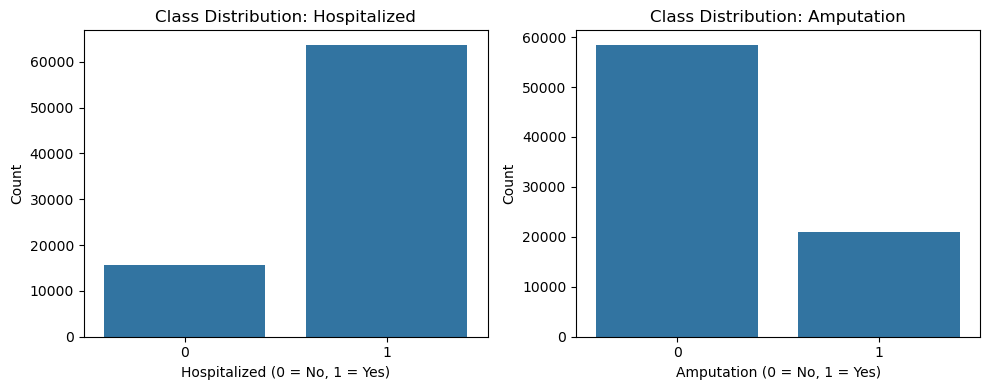

In [5]:
# CELL 5: Exploratory Data Analysis (EDA)

# I inspected the dataset shape after preprocessing
print("Dataset shape after preprocessing:", df.shape)

# I checked class distributions for both target variables
print("\nClass distribution for Hospitalization:")
print(df['Hospitalized'].value_counts())

print("\nClass distribution for Amputation:")
print(df['Amputation'].value_counts())

# I visualised class imbalance
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.countplot(x=df['Hospitalized'])
plt.title("Class Distribution: Hospitalized")
plt.xlabel("Hospitalized (0 = No, 1 = Yes)")
plt.ylabel("Count")

plt.subplot(1,2,2)
sns.countplot(x=df['Amputation'])
plt.title("Class Distribution: Amputation")
plt.xlabel("Amputation (0 = No, 1 = Yes)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


## Step 6 — Train/Test Split and Baseline Classifier

I split the dataset into training and test sets using an 80/20 ratio with stratification to preserve the original class distribution. Stratification was particularly important given the imbalance in the hospitalisation label.

I then implemented a majority-class baseline classifier to establish a minimum performance benchmark. Although this baseline achieved high recall by predicting only the dominant class, it failed to identify non-hospitalised cases, demonstrating the need for more sophisticated models.

In [6]:
# CELL 6: Train/test split and baseline classifier

# I selected the cleaned text as input features
X = df['clean_text']

# I created targets for both prediction tasks
y_hosp = df['Hospitalized']
y_amp = df['Amputation']

# I split the dataset into training and testing sets (80/20) using stratification
X_train, X_test, y_train_h, y_test_h = train_test_split(
    X,
    y_hosp,
    test_size=0.2,
    random_state=42,
    stratify=y_hosp
)

X_train2, X_test2, y_train_a, y_test_a = train_test_split(
    X,
    y_amp,
    test_size=0.2,
    random_state=42,
    stratify=y_amp
)

print("Training samples (Hospitalization):", len(X_train))
print("Test samples (Hospitalization):", len(X_test))

# I established a majority-class baseline for hospitalization
majority_class_h = y_train_h.mode()[0]
baseline_preds_h = [majority_class_h] * len(y_test_h)

# I evaluated baseline performance
baseline_accuracy = accuracy_score(y_test_h, baseline_preds_h)
baseline_precision = precision_score(y_test_h, baseline_preds_h, zero_division=0)
baseline_recall = recall_score(y_test_h, baseline_preds_h, zero_division=0)
baseline_f1 = f1_score(y_test_h, baseline_preds_h, zero_division=0)

print("\nBaseline Classifier (Hospitalization)")
print("Majority class predicted:", majority_class_h)
print("Accuracy:", baseline_accuracy)
print("Precision:", baseline_precision)
print("Recall:", baseline_recall)
print("F1 Score:", baseline_f1)


Training samples (Hospitalization): 63480
Test samples (Hospitalization): 15871

Baseline Classifier (Hospitalization)
Majority class predicted: 1
Accuracy: 0.8027849536891185
Precision: 0.8027849536891185
Recall: 1.0
F1 Score: 0.8906053404166084


## Step 7 — TF-IDF Vectorisation and Naïve Bayes Classification

I transformed the narrative text into TF-IDF feature vectors to represent term importance across documents. Using these features, I trained a Multinomial Naïve Bayes classifier as a traditional NLP baseline.

Naïve Bayes was chosen because it is computationally efficient and commonly used for text classification. However, due to its independence assumptions and sensitivity to class imbalance, its performance was mainly used as a comparative benchmark rather than a deployment candidate.

In [7]:
# CELL 7: TF-IDF vectorisation and Naïve Bayes classification

# I created a TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)

# I fitted the vectorizer on the training text and transformed both sets
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# I trained a Multinomial Naïve Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train_h)

# I generated predictions on the test set
nb_pred = nb_model.predict(X_test_tfidf)

# I evaluated the model
nb_accuracy = accuracy_score(y_test_h, nb_pred)
nb_precision = precision_score(y_test_h, nb_pred, zero_division=0)
nb_recall = recall_score(y_test_h, nb_pred, zero_division=0)
nb_f1 = f1_score(y_test_h, nb_pred, zero_division=0)

print("Naïve Bayes Classifier (Hospitalization)")
print("Accuracy:", nb_accuracy)
print("Precision:", nb_precision)
print("Recall:", nb_recall)
print("F1 Score:", nb_f1)

print("\nClassification Report:")
print(classification_report(y_test_h, nb_pred, zero_division=0))


Naïve Bayes Classifier (Hospitalization)
Accuracy: 0.8824270682376661
Precision: 0.9434069966566093
Recall: 0.9080134997252963
F1 Score: 0.9253719404895216

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.78      0.72      3130
           1       0.94      0.91      0.93     12741

    accuracy                           0.88     15871
   macro avg       0.81      0.84      0.82     15871
weighted avg       0.89      0.88      0.89     15871



## Step 8 — TF-IDF with Logistic Regression

Using the same TF-IDF features, I trained a Logistic Regression classifier. Logistic Regression is well-suited to high-dimensional sparse text data and often performs strongly in NLP classification tasks.

After training, I evaluated the model using accuracy, precision, recall, and F1-score. The classification report showed improved balance across both classes compared to Naïve Bayes, making this model a strong candidate for further refinement.


In [8]:
# CELL 8: TF-IDF with Logistic Regression

# I initialised and trained the classifier
log_model = LogisticRegression(max_iter=2000)
log_model.fit(X_train_tfidf, y_train_h)

# I generated predictions on the test set
log_pred = log_model.predict(X_test_tfidf)

# I evaluated the model
log_accuracy = accuracy_score(y_test_h, log_pred)
log_precision = precision_score(y_test_h, log_pred, zero_division=0)
log_recall = recall_score(y_test_h, log_pred, zero_division=0)
log_f1 = f1_score(y_test_h, log_pred, zero_division=0)

print("Logistic Regression Classifier (Hospitalization)")
print("Accuracy:", log_accuracy)
print("Precision:", log_precision)
print("Recall:", log_recall)
print("F1 Score:", log_f1)

print("\nClassification Report:")
print(classification_report(y_test_h, log_pred, zero_division=0))


Logistic Regression Classifier (Hospitalization)
Accuracy: 0.9061180769957785
Precision: 0.948640242443576
Recall: 0.93360018836826
F1 Score: 0.9410601265822784

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      3130
           1       0.95      0.93      0.94     12741

    accuracy                           0.91     15871
   macro avg       0.85      0.86      0.86     15871
weighted avg       0.91      0.91      0.91     15871



## Step 9 — Tokenisation and Sequence Padding for Deep Learning Models

To prepare the text for deep learning models, I converted each narrative into a sequence of integer tokens using a tokenizer fitted only on the training data to prevent leakage. I limited the vocabulary size to reduce overfitting.

I then applied padding so that all sequences had a fixed length. A maximum length of 150 tokens was selected based on earlier exploratory analysis, ensuring most narratives were captured while keeping computation efficient.

In [9]:
# CELL 9: Tokenisation and sequence padding for deep learning models

# I created a tokenizer with a limited vocabulary size
vocab_size = 5000
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

# I fitted the tokenizer on the training data
tokenizer.fit_on_texts(X_train)

# I converted the text into sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# I applied padding to ensure fixed-length input sequences
max_len = 150
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# I checked the matrix shapes
print("Training padded shape:", X_train_pad.shape)
print("Testing padded shape:", X_test_pad.shape)


Training padded shape: (63480, 150)
Testing padded shape: (15871, 150)


## Step 10 — Bidirectional LSTM Model

I built a Bidirectional LSTM model to capture sequential patterns in the narratives. The bidirectional structure allowed the model to learn context from both earlier and later parts of the text.

The architecture included an embedding layer, a BiLSTM layer, and dense layers for classification. After training the model, I evaluated its performance on the test set and observed strong results, although training was computationally more expensive than traditional models.

The deprecation warning related to the input_length argument does not affect model behaviour and reflects a change in Keras API recommendations rather than an implementation error.

In [10]:
# CELL 10: Bidirectional LSTM model

# I built the model architecture
model_lstm = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# I compiled the model
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# I trained the model
history = model_lstm.fit(
    X_train_pad, y_train_h,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)

# I generated predictions
y_pred_lstm = (model_lstm.predict(X_test_pad) > 0.5).astype("int32")

# I evaluated the model
lstm_accuracy = accuracy_score(y_test_h, y_pred_lstm)
lstm_precision = precision_score(y_test_h, y_pred_lstm, zero_division=0)
lstm_recall = recall_score(y_test_h, y_pred_lstm, zero_division=0)
lstm_f1 = f1_score(y_test_h, y_pred_lstm, zero_division=0)

print("\nBidirectional LSTM Classifier (Hospitalization)")
print("Accuracy:", lstm_accuracy)
print("Precision:", lstm_precision)
print("Recall:", lstm_recall)
print("F1 Score:", lstm_f1)


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 71s 85ms/step - accuracy: 0.9000 - loss: 0.2300 - val_accuracy: 0.9110 - val_loss: 0.1946
Epoch 2/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 71s 89ms/step - accuracy: 0.9014 - loss: 0.2084 - val_accuracy: 0.9152 - val_loss: 0.1959
Epoch 3/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 73s 91ms/step - accuracy: 0.9192 - loss: 0.1857 - val_accuracy: 0.9174 - val_loss: 0.2002
Epoch 4/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 75s 94ms/step - accuracy: 0.9209 - loss: 0.1841 - val_accuracy: 0.9086 - val_loss: 0.1961
Epoch 5/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 73s 92ms/step - accuracy: 0.9238 - loss: 0.1746 - val_accuracy: 0.9171 - val_loss: 0.1910
Epoch 6/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 81s 102ms/step - accuracy: 0.9305 - loss: 0.1617 - val_accuracy: 0.9181 - val_loss: 0.1974
Epoch 7/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 74s 93ms/step - accuracy: 0.9345 - loss: 0.1536 - val_accuracy: 0.9135 - val_loss: 0.2060
Epoch 8/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 74s 94ms/step - accuracy: 0.9387 - loss: 0.1427 -

## Step 11 — DistilBERT Embeddings with Logistic Regression

I implemented a transformer-based approach using DistilBERT sentence embeddings to capture deeper semantic meaning in the narratives. Each report was converted into a dense vector representation using a pretrained transformer model.

I then trained a Logistic Regression classifier on these embeddings. This approach provided strong performance while avoiding the computational cost of full transformer fine-tuning.

In [11]:
# CELL 11: DistilBERT Transformer 

# I loaded the pretrained DistilBERT sentence embedder
bert_embedder = SentenceTransformer('distilbert-base-nli-mean-tokens')

# I encoded the training text with progress bars
X_train_embed = []
print("Encoding training data with DistilBERT...")
for text in tqdm(X_train, desc="Training embeddings"):
    emb = bert_embedder.encode(text)
    X_train_embed.append(emb)

# I encoded the test text
X_test_embed = []
print("\nEncoding test data with DistilBERT...")
for text in tqdm(X_test, desc="Test embeddings"):
    emb = bert_embedder.encode(text)
    X_test_embed.append(emb)

# I converted the embeddings to NumPy arrays
X_train_embed = np.array(X_train_embed)
X_test_embed = np.array(X_test_embed)

# I trained a Logistic Regression classifier on the embeddings
bert_clf = LogisticRegression(max_iter=2000)
print("\nTraining Logistic Regression classifier...")
bert_clf.fit(X_train_embed, y_train_h)

# I generated predictions
print("Evaluating on test set...")
bert_pred = bert_clf.predict(X_test_embed)

# I evaluated the model
bert_accuracy = accuracy_score(y_test_h, bert_pred)
bert_precision = precision_score(y_test_h, bert_pred, zero_division=0)
bert_recall = recall_score(y_test_h, bert_pred, zero_division=0)
bert_f1 = f1_score(y_test_h, bert_pred, zero_division=0)

print("\nDistilBERT Transformer Classifier Results (Hospitalization)")
print("Accuracy:", bert_accuracy)
print("Precision:", bert_precision)
print("Recall:", bert_recall)
print("F1 Score:", bert_f1)


Encoding training data with DistilBERT...


Training embeddings: 100%|██████████| 63480/63480 [45:14<00:00, 23.39it/s]  



Encoding test data with DistilBERT...


Test embeddings: 100%|██████████| 15871/15871 [11:03<00:00, 23.90it/s]



Training Logistic Regression classifier...
Evaluating on test set...

DistilBERT Transformer Classifier Results (Hospitalization)
Accuracy: 0.9029046688929494
Precision: 0.9466422076886266
Recall: 0.9315595322188212
F1 Score: 0.9390403101388505


## Step 12 — Handling Class Imbalance with SMOTE

Because the hospitalisation label was highly imbalanced, I applied SMOTE to the TF-IDF training data to synthetically oversample the minority class. This helped the models learn more balanced decision boundaries without duplicating samples.

I retrained both Naïve Bayes and Logistic Regression on the resampled data and compared performance against their original versions to assess the impact of balancing.

In [12]:
# CELL 12: Handling class imbalance with SMOTE

# I applied SMOTE to balance the training data
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_tfidf, y_train_h)

print("Original training size:", X_train_tfidf.shape, " --> Resampled:", X_train_resampled.shape)
print("Original class balance:", y_train_h.value_counts().to_dict())
print("After SMOTE:", pd.Series(y_train_resampled).value_counts().to_dict())

# I retrained Naïve Bayes using the resampled data
nb_model_smote = MultinomialNB()
nb_model_smote.fit(X_train_resampled, y_train_resampled)
nb_smote_pred = nb_model_smote.predict(X_test_tfidf)

nb_smote_accuracy = accuracy_score(y_test_h, nb_smote_pred)
nb_smote_precision = precision_score(y_test_h, nb_smote_pred, zero_division=0)
nb_smote_recall = recall_score(y_test_h, nb_smote_pred, zero_division=0)
nb_smote_f1 = f1_score(y_test_h, nb_smote_pred, zero_division=0)

print("\nNaïve Bayes + SMOTE")
print("Accuracy:", nb_smote_accuracy)
print("Precision:", nb_smote_precision)
print("Recall:", nb_smote_recall)
print("F1 Score:", nb_smote_f1)

# I retrained Logistic Regression using the resampled data
log_model_smote = LogisticRegression(max_iter=2000)
log_model_smote.fit(X_train_resampled, y_train_resampled)
log_smote_pred = log_model_smote.predict(X_test_tfidf)

log_smote_accuracy = accuracy_score(y_test_h, log_smote_pred)
log_smote_precision = precision_score(y_test_h, log_smote_pred, zero_division=0)
log_smote_recall = recall_score(y_test_h, log_smote_pred, zero_division=0)
log_smote_f1 = f1_score(y_test_h, log_smote_pred, zero_division=0)

print("\nLogistic Regression + SMOTE")
print("Accuracy:", log_smote_accuracy)
print("Precision:", log_smote_precision)
print("Recall:", log_smote_recall)
print("F1 Score:", log_smote_f1)


Original training size: (63480, 5000)  --> Resampled: (101922, 5000)
Original class balance: {1: 50961, 0: 12519}
After SMOTE: {1: 50961, 0: 50961}

Naïve Bayes + SMOTE
Accuracy: 0.8598702035158465
Precision: 0.9781758661453124
Recall: 0.8442822384428224
F1 Score: 0.9063105569129666

Logistic Regression + SMOTE
Accuracy: 0.9105916451389326
Precision: 0.9814594318761695
Recall: 0.9057373832509222
F1 Score: 0.9420792685415731


## Step 13 — BiLSTM with Class Weights to Handle Imbalance

Instead of oversampling, I addressed imbalance in the BiLSTM model using class weighting. This approach increased the penalty for misclassifying minority cases during training while preserving the original sequence structure.

Class weighting improved recall for non-hospitalised cases and produced a more balanced model without introducing synthetic samples.

In [13]:
# CELL 13: BiLSTM with class weights to handle imbalance

# I computed class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=y_train_h
)
class_weights = {0: class_weights_array[0], 1: class_weights_array[1]}
print("Class weights used:", class_weights)

# I rebuilt the BiLSTM model architecture
model_lstm_balanced = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model_lstm_balanced.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# I trained the model using class weights
history_balanced = model_lstm_balanced.fit(
    X_train_pad,
    y_train_h,
    epochs=3,
    batch_size=64,
    validation_split=0.2,
    class_weight=class_weights,
    verbose=1
)

# I generated predictions
y_pred_balanced = (model_lstm_balanced.predict(X_test_pad) > 0.5).astype("int32")

# I evaluated the model
lstm_bal_accuracy = accuracy_score(y_test_h, y_pred_balanced)
lstm_bal_precision = precision_score(y_test_h, y_pred_balanced, zero_division=0)
lstm_bal_recall = recall_score(y_test_h, y_pred_balanced, zero_division=0)
lstm_bal_f1 = f1_score(y_test_h, y_pred_balanced, zero_division=0)

print("\nBiLSTM with Class Weights — Results (Hospitalization)")
print("Accuracy:", lstm_bal_accuracy)
print("Precision:", lstm_bal_precision)
print("Recall:", lstm_bal_recall)
print("F1 Score:", lstm_bal_f1)


Class weights used: {0: np.float64(2.5353462736640306), 1: np.float64(0.6228292223465003)}


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
794/794 ━━━━━━━━━━━━━━━━━━━━ 71s 84ms/step - accuracy: 0.8783 - loss: 0.2756 - val_accuracy: 0.9017 - val_loss: 0.2517
Epoch 2/3
794/794 ━━━━━━━━━━━━━━━━━━━━ 65s 82ms/step - accuracy: 0.9066 - loss: 0.2166 - val_accuracy: 0.9065 - val_loss: 0.2426
Epoch 3/3
794/794 ━━━━━━━━━━━━━━━━━━━━ 68s 85ms/step - accuracy: 0.9157 - loss: 0.1948 - val_accuracy: 0.9134 - val_loss: 0.2171
496/496 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step

BiLSTM with Class Weights — Results (Hospitalization)
Accuracy: 0.9073782370361035
Precision: 0.9863640286528006
Recall: 0.8970253512283181
F1 Score: 0.9395757974350543


## Step 14 — DistilBERT Refinement Using Threshold Tuning

To prioritise sensitivity to severe cases, I lowered the classification threshold for the DistilBERT-based model from 0.50 to 0.45. This adjustment reflected real-world safety priorities, where missing a serious injury is more costly than raising a false alarm.

I evaluated the refined predictions and observed improved recall with only a small reduction in precision..


In [14]:
# CELL 14: Refining DistilBERT using probability threshold tuning

# I obtained predicted probabilities
bert_proba = bert_clf.predict_proba(X_test_embed)[:, 1]

# I applied a lower threshold to improve minority recall
adjusted_threshold = 0.45
bert_pred_adjusted = (bert_proba > adjusted_threshold).astype(int)

# I evaluated the refined predictions
bert_thr_accuracy = accuracy_score(y_test_h, bert_pred_adjusted)
bert_thr_precision = precision_score(y_test_h, bert_pred_adjusted, zero_division=0)
bert_thr_recall = recall_score(y_test_h, bert_pred_adjusted, zero_division=0)
bert_thr_f1 = f1_score(y_test_h, bert_pred_adjusted, zero_division=0)

print(f"DistilBERT Classifier After Threshold Tuning (threshold={adjusted_threshold})")
print("Accuracy:", bert_thr_accuracy)
print("Precision:", bert_thr_precision)
print("Recall:", bert_thr_recall)
print("F1 Score:", bert_thr_f1)


DistilBERT Classifier After Threshold Tuning (threshold=0.45)
Accuracy: 0.8995652447860878
Precision: 0.9366920003134059
Recall: 0.938309394866965
F1 Score: 0.9375


## Step 15 — Model Comparison Table for Evaluation

I summarised the performance of all models in a comparison table, including baseline, traditional models, deep learning models, and imbalance-adjusted versions. Presenting metrics side-by-side made it easier to identify the most effective and practical approach.

In [15]:
# CELL 15: Model comparison table for evaluation section

# I created a table summarising performance metrics for all models
comparison_data = {
    'Model': [
        'Baseline (Majority Class)',
        'Naive Bayes',
        'Naive Bayes + SMOTE',
        'Logistic Regression',
        'Logistic Regression + SMOTE',
        'BiLSTM',
        'BiLSTM + Class Weights',
        'DistilBERT',
        'DistilBERT + Threshold 0.45'
    ],
    'Accuracy': [
        baseline_accuracy,
        nb_accuracy,
        nb_smote_accuracy,
        log_accuracy,
        log_smote_accuracy,
        lstm_accuracy,
        lstm_bal_accuracy,
        bert_accuracy,
        bert_thr_accuracy
    ],
    'Precision': [
        baseline_precision,
        nb_precision,
        nb_smote_precision,
        log_precision,
        log_smote_precision,
        lstm_precision,
        lstm_bal_precision,
        bert_precision,
        bert_thr_precision
    ],
    'Recall': [
        baseline_recall,
        nb_recall,
        nb_smote_recall,
        log_recall,
        log_smote_recall,
        lstm_recall,
        lstm_bal_recall,
        bert_recall,
        bert_thr_recall
    ],
    'F1 Score': [
        baseline_f1,
        nb_f1,
        nb_smote_f1,
        log_f1,
        log_smote_f1,
        lstm_f1,
        lstm_bal_f1,
        bert_f1,
        bert_thr_f1
    ]
}

results_df = pd.DataFrame(comparison_data)
results_df


,Model,Accuracy,Precision,Recall,F1 Score
0,Baseline (Majority Class),0.802785,0.802785,1.000000,0.890605
1,Naive Bayes,0.882427,0.943407,0.908013,0.925372
2,Naive Bayes + SMOTE,0.859870,0.978176,0.844282,0.906311
3,Logistic Regression,0.906118,0.948640,0.933600,0.941060
4,Logistic Regression + SMOTE,0.910592,0.981459,0.905737,0.942079
5,BiLSTM,0.899250,0.954034,0.918766,0.936068
6,BiLSTM + Class Weights,0.907378,0.986364,0.897025,0.939576
7,DistilBERT,0.902905,0.946642,0.931560,0.939040
8,DistilBERT + Threshold 0.45,0.899565,0.936692,0.938309,0.937500


## Step 16 — Visualising model performance (F1 score comparison)

I created a bar chart comparing F1 scores across all models. F1-score was chosen because it balances precision and recall, making it suitable for imbalanced classification tasks.

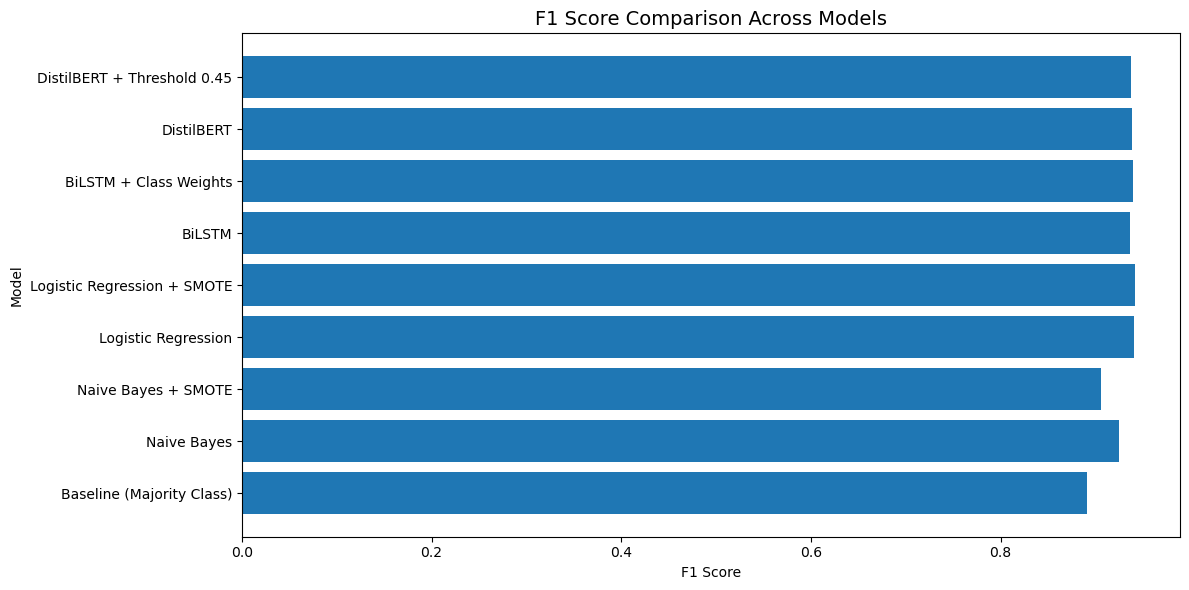

In [16]:
# CELL 16: Bar chart of F1 scores for all models

# I extracted model names and their F1 scores from the comparison table
model_names = results_df['Model']
f1_scores = results_df['F1 Score']

plt.figure(figsize=(12,6))

# I used a horizontal bar chart for readability due to the long model names
plt.barh(model_names, f1_scores)
plt.title("F1 Score Comparison Across Models", fontsize=14)
plt.xlabel("F1 Score")
plt.ylabel("Model")

plt.tight_layout()

# I saved the visual so it can be included in the written report
plt.savefig("f1_score_comparison.png", dpi=300)
plt.show()


## Step 17 — Confusion matrix for Logistic Regression with SMOTE

I generated a confusion matrix to examine how well the SMOTE-balanced Logistic Regression model identified both hospitalised and non-hospitalised cases. The results confirmed improved balance compared to the baseline classifier.

<Figure size 600x600 with 0 Axes>

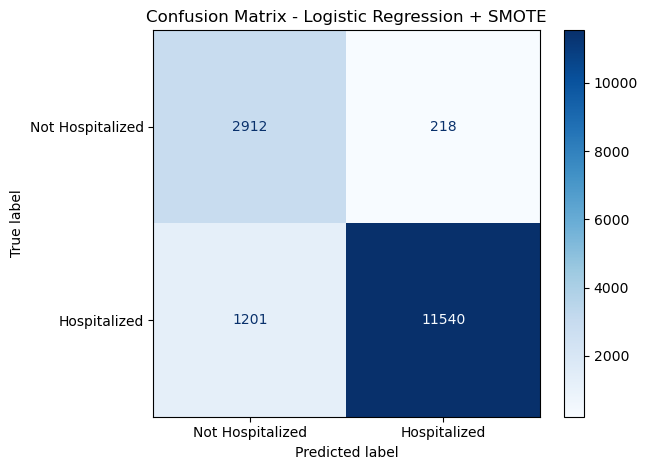

In [17]:
# CELL 17: Confusion matrix for Logistic Regression + SMOTE

# I generated a confusion matrix to visualise true positives, true negatives,
# false positives and false negatives for the SMOTE-trained logistic regression model.
cm = confusion_matrix(y_test_h, log_smote_pred)

# I used ConfusionMatrixDisplay for a clearer labelled plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Hospitalized", "Hospitalized"])

plt.figure(figsize=(6,6))
disp.plot(values_format='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression + SMOTE")
plt.tight_layout()

# I saved the confusion matrix as an image for inclusion in the final report
plt.savefig("confusion_matrix_log_smote.png", dpi=300)
plt.show()


## Step 18 — Training curves for BiLSTM before class-weighting

I plotted training and validation loss and accuracy curves for the BiLSTM model. These plots helped assess learning stability and identify signs of overfitting during training.

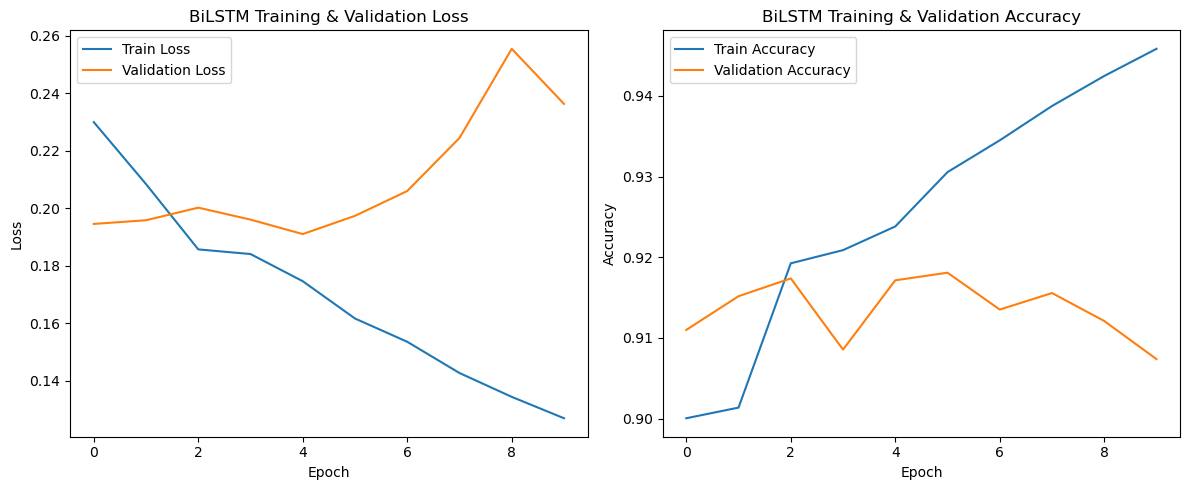

In [18]:
# CELL 18: Training curves for BiLSTM before class-weighting

plt.figure(figsize=(12,5))

# I plotted the training and validation loss across epochs
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("BiLSTM Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# I plotted the training and validation accuracy across epochs
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("BiLSTM Training & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()

# I saved the visual so it could be used in the final report
plt.savefig("bilstm_training_curves.png", dpi=300)
plt.show()


## Step 19 — Word clouds for exploratory analysis

To gain an intuitive understanding of language patterns, I generated separate word clouds for hospitalised and non-hospitalised cases. These visuals highlighted terms associated with injury severity and workplace hazards.

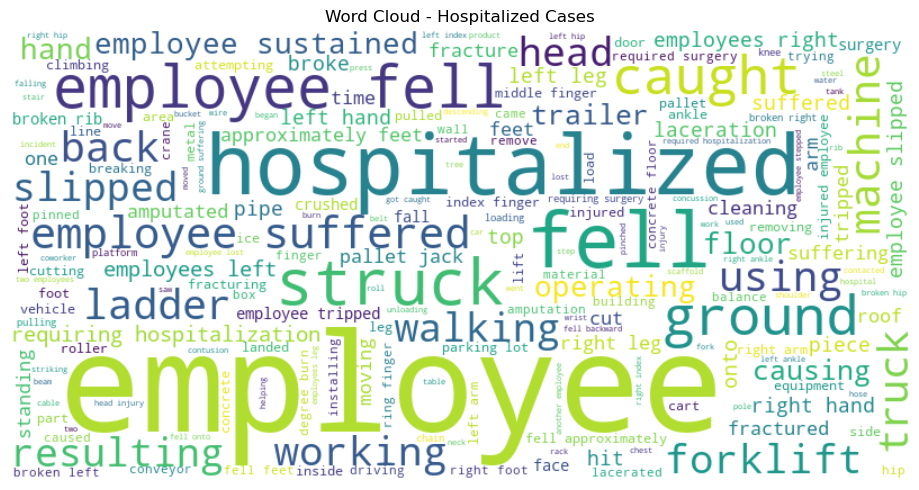

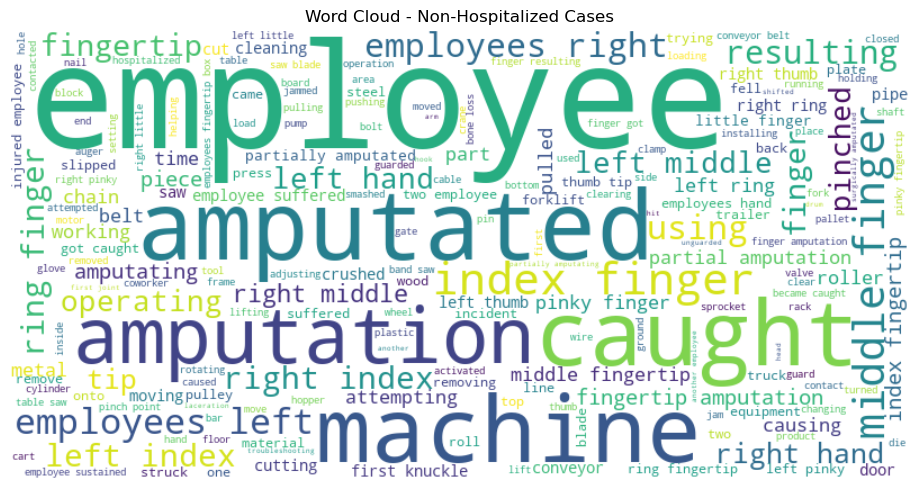

In [19]:
# CELL 19: Word clouds for EDA

# I created a word cloud using all narratives where the worker was hospitalized
hospitalized_text = " ".join(df[df['Hospitalized'] == 1]['clean_text'])
wc_hosp = WordCloud(width=800, height=400, background_color='white').generate(hospitalized_text)

plt.figure(figsize=(10,5))
plt.imshow(wc_hosp, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Hospitalized Cases")
plt.tight_layout()
plt.savefig("wordcloud_hospitalized.png", dpi=300)
plt.show()

# I repeated the same process for cases where the worker was not hospitalized
not_hospitalized_text = " ".join(df[df['Hospitalized'] == 0]['clean_text'])
wc_not = WordCloud(width=800, height=400, background_color='white').generate(not_hospitalized_text)

plt.figure(figsize=(10,5))
plt.imshow(wc_not, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Non-Hospitalized Cases")
plt.tight_layout()
plt.savefig("wordcloud_non_hospitalized.png", dpi=300)
plt.show()


## Step 20 — Most frequent keywords in OSHA narratives

To understand which terms appeared most often across all incident descriptions,
I extracted the top 20 most frequent words from the cleaned narratives using a CountVectorizer.

This provided insight into common hazards, actions, and terminology found in OSHA reports.
The resulting bar chart highlights patterns in the data that align with occupational safety risks,
such as falls, machinery, injuries, and body parts.
I saved the visual for use in the exploratory analysis section of the report.


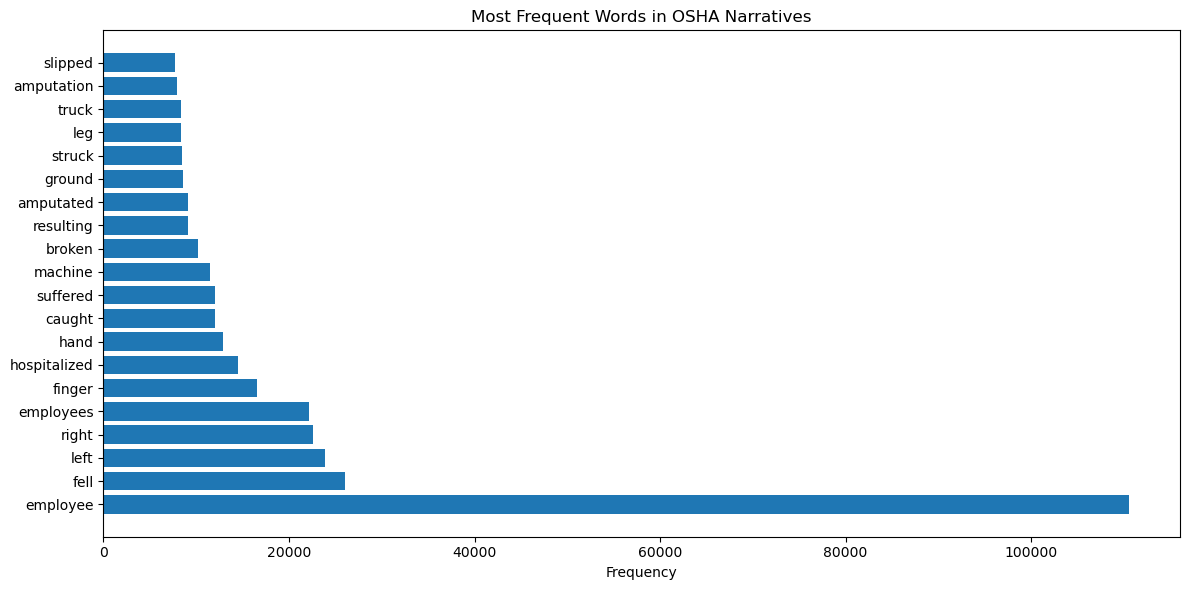

In [20]:
# CELL 20: Most frequent keywords in narratives

# I used a CountVectorizer to extract the 20 most common words
vectorizer = CountVectorizer(stop_words='english', max_features=20)
word_counts = vectorizer.fit_transform(df['clean_text'])

# I calculated total word frequencies
sum_words = word_counts.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# I separated the words and counts for plotting
top_words, counts = zip(*words_freq)

plt.figure(figsize=(12,6))
plt.barh(top_words, counts)
plt.title("Most Frequent Words in OSHA Narratives")
plt.xlabel("Frequency")
plt.tight_layout()

# I saved the visual for use in the report
plt.savefig("top_keywords.png", dpi=300)
plt.show()


## Step 21 — Narrative length distribution

To understand how long typical OSHA incident descriptions were,  
I calculated the number of words in each cleaned narrative and plotted a histogram.  
This distribution helped determine an appropriate sequence length for deep learning models.  
I saved the visual for inclusion in the exploratory analysis section of the report.


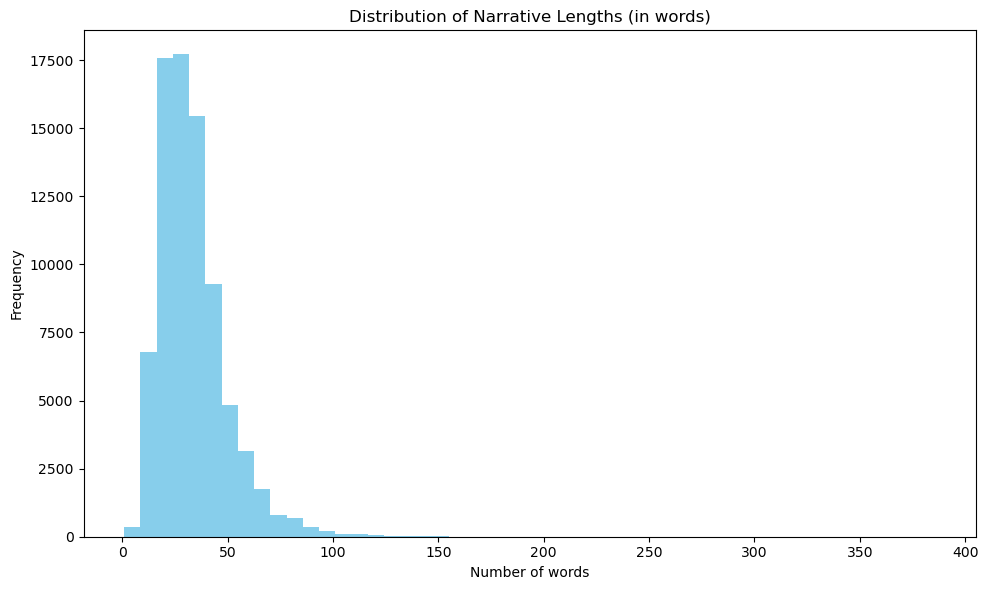

In [21]:
# CELL 21: Narrative length distribution

# I calculated the number of words in each narrative
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
plt.hist(df['text_length'], bins=50, color='skyblue')
plt.title("Distribution of Narrative Lengths (in words)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.tight_layout()

# I saved the visual for the report
plt.savefig("narrative_length_distribution.png", dpi=300)
plt.show()


## Step 22 — ROC and Precision–Recall curves for Logistic Regression with SMOTE

To evaluate how well the SMOTE-balanced Logistic Regression model separated the two classes,
I generated a Receiver Operating Characteristic (ROC) curve and a Precision–Recall curve.

- The **ROC curve** shows the trade-off between true positive rate and false positive rate.
- The **Precision–Recall curve** is particularly useful for imbalanced datasets, because it focuses on
  how well the model identifies positive cases without being influenced by the majority class.

I calculated the Area Under the ROC Curve (AUC) and saved both visuals for inclusion in the report.


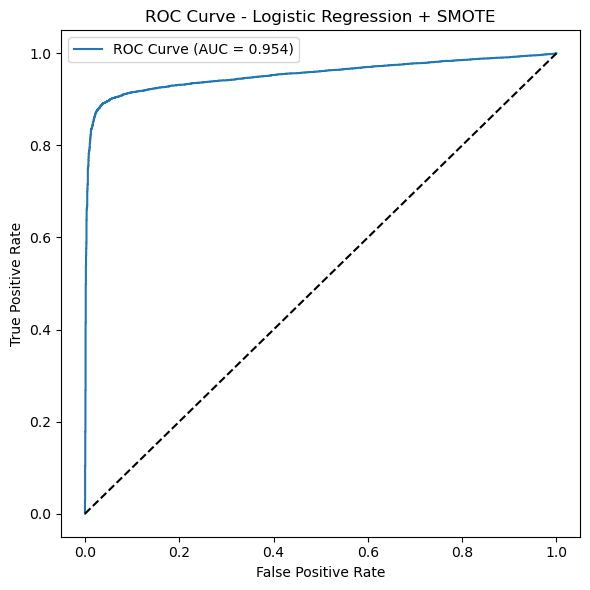

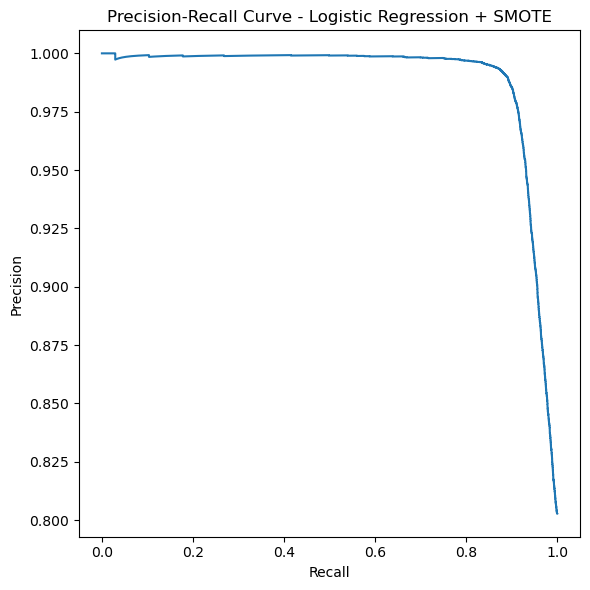

In [22]:
# CELL 22: ROC and Precision-Recall Curves for Logistic Regression + SMOTE

# I extracted predicted probabilities for the positive class
log_probs = log_model_smote.predict_proba(X_test_tfidf)[:, 1]

# ----- ROC Curve -----
# I calculated false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test_h, log_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression + SMOTE")
plt.legend()
plt.tight_layout()

# I saved the ROC visual
plt.savefig("roc_log_smote.png", dpi=300)
plt.show()

# ----- Precision–Recall Curve -----
# I calculated precision and recall values
precision, recall, _ = precision_recall_curve(y_test_h, log_probs)

plt.figure(figsize=(6,6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression + SMOTE")
plt.tight_layout()

# I saved the PR curve visual
plt.savefig("pr_log_smote.png", dpi=300)
plt.show()
